In [1]:
# Load required libraries
import geopandas as gpd
import numpy as np
import os
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from unidecode import unidecode
import glob
import csv
from datetime import datetime
import dask.dataframe as dd
import dask_geopandas as dg
from dask.distributed import Client
import time


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Q:\UserTemp\ubach\AppData\Local\Temp\63\ipykernel_250952\775321219.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https

In [17]:
def overlay(left, right):
    return (
        left.sjoin(right.assign(right_geometry=right.geometry))
        .assign(geometry=lambda x: x.geometry.intersection(x.right_geometry))
        .drop(columns="right_geometry")
    )

In [9]:
# Folder structure
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
outdata_f = os.path.join(indata_f, 'OutputData', 'test0407')
if not os.path.exists(outdata_f):
    # Create the folder if it doesn't exist
    os.makedirs(outdata_f)

# 0 PREPARE A LOG FILE FOR QC
log_file = 'log_GQA_Step1.csv'
log_path = os.path.join(outdata_f, log_file)

#define reading engines
engines = {
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True},
    'pyogrio+arrow+bbox': {'engine': 'pyogrio', 'use_arrow': True, 'bbox': tuple(agl_city.total_bounds)}
          }

# Path to aglomeration data
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')
# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery',**engines['pyogrio+arrow'])


In [3]:
# 1 READ URBAN CENTRES
# Read shapefile
uc_file_path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG.shp')
# Read the GeoPackage file
uc = gpd.read_file(uc_file_path)

In [11]:
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
ctry_code = 'FR'
ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'


In [21]:
cities_ls = ['Bordeaux', 'Kaunas', 'København', 'Girona']

In [34]:
# Loop through test cities
for cityLocalName in cities_ls[:1]:
    print(str(cityLocalName))
    start_time = datetime.now()
    print(str(start_time))
    uc_city = uc.query(f'HDENS_NAME == "{cityLocalName}"')
    ctry_code = uc_city.CNTR_CODE.values.astype(str)[0]
    cityLocalName_unicode = unidecode(cityLocalName)
    # load aglomeration boundary
    agl_city = agls.query(f'agglomerationName_localName == "{cityLocalName}"')
    if agl_city.empty:
        agglomerationId_identifier = 'NotAvailable'
        print ("agglomerationId_identifier")
    else:
        agglomerationId_identifier = agl_city.agglomerationId_identifier.values.astype(str)[0]
        print ("agglomerationId_identifier")

        # Load noise data (ncm)
        ncm = gpd.read_file(ncm_file_path, layer=layerName, **engines['pyogrio+arrow+bbox'], columns=['category', 'geometry'])
        print ("ncm")

        # Perform spatial overlay (intersection) 
        ncm_agl = gpd.overlay(ncm, agl_city, how='intersection')
        #ncm_dg = dg.from_geopandas(ncm, npartitions=10) #dask_geopandas
        #ncm_dg_agl = overlay(ncm_dg, agl_city).compute()

        # Aggregate the area with lower band values (quieter bands)
        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
        ncm_agl_city.category.fillna(0)

        


        
        

Bordeaux
2024-07-04 12:09:20.261714
agglomerationId_identifier


ncm


Q:\UserTemp\ubach\AppData\Local\Temp\63\ipykernel_250952\3307567178.py:29: UserWarning: `keep_geom_type=True` in overlay resulted in 16549 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')


In [35]:
ncm_agl_city

,category,agglomerationId_identifier_1,id_1,agglomerationName_localName_1,agglomerationName_localNameLanguage_1,agglomerationName_nameEng_1,size_1,numberOfInhabitants_1,applicableSource_1,inspireId_localId_1,...,inspireId_localId_2,inspireId_namespace_2,inspireId_versionId_2,sourceIdentifier_2,reportNetEnvelopeFileId_2,countryCode_2,geometry_error_description_2,latestDelivery_2,dateReleased_2,geometry
0,Lden5559,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3470645.126 2474606.132, 34706..."
1,Lden6064,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3476552.961 2468358.923, 34765..."
2,Lden6569,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3468624.912 2475568.530, 34686..."
3,Lden7074,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3497601.623 2484630.188, 34975..."
4,LdenGreaterThan75,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3497587.403 2484690.909, 34975..."
5,LdenGreaterThan75,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,"MULTIPOLYGON (((3497236.380 2484470.134, 34972..."
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3487604.269 2495526.161, 34878..."


In [44]:
ncm

,category,geometry
0,Lden5559,"MULTIPOLYGON (((3487482.480 2495383.601, 34874..."
1,Lden6064,"MULTIPOLYGON (((3489169.833 2493951.712, 34891..."
2,Lden6569,"MULTIPOLYGON (((3487471.536 2495361.087, 34874..."
3,Lden7074,"MULTIPOLYGON (((3490153.762 2493507.859, 34901..."
4,LdenGreaterThan75,"MULTIPOLYGON (((3492783.025 2486067.328, 34927..."


<AxesSubplot: >

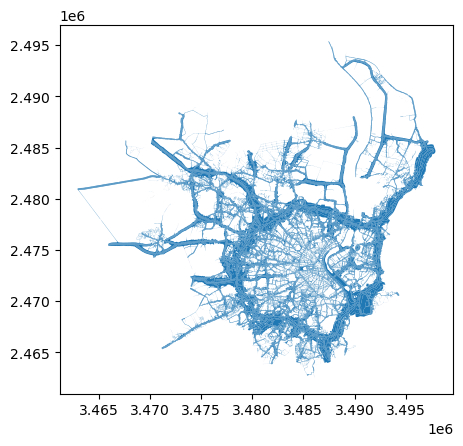

In [40]:
ncm.plot()

<AxesSubplot: >

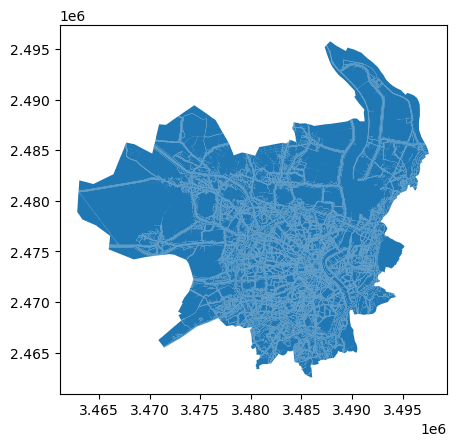

In [36]:
ncm_agl_city.plot()

In [38]:
ncm_agl_city.geometry.area.sum()

576856332.6168654

In [39]:
# Loop through test cities
for cityLocalName in cities_ls[:1]:
    print(str(cityLocalName))
    start_time = datetime.now()
    print(str(start_time))
    uc_city = uc.query(f'HDENS_NAME == "{cityLocalName}"')
    ctry_code = uc_city.CNTR_CODE.values.astype(str)[0]
    cityLocalName_unicode = unidecode(cityLocalName)
    # load aglomeration boundary
    agl_city = agls.query(f'agglomerationName_localName == "{cityLocalName}"')
    if agl_city.empty:
        agglomerationId_identifier = 'NotAvailable'
        print ("agglomerationId_identifier")
    else:
        agglomerationId_identifier = agl_city.agglomerationId_identifier.values.astype(str)[0]
        print ("agglomerationId_identifier")

        # Load noise data (ncm)
        ncm = gpd.read_file(ncm_file_path, layer=layerName, **engines['pyogrio+arrow+bbox'], columns=['category', 'geometry'])
        print ("ncm")

        # Perform spatial overlay (intersection) 
        ncm_agl = gpd.overlay(ncm, agl_city, how='identity')
        ncm_agl.category.fillna(0)

Bordeaux
2024-07-04 12:19:08.388880
agglomerationId_identifier
ncm


In [41]:
ncm_agl.geometry.area.sum()

192674377.67898437

In [43]:
ncm_agl

,category,agglomerationId_identifier,id,agglomerationName_localName,agglomerationName_localNameLanguage,agglomerationName_nameEng,size,numberOfInhabitants,applicableSource,inspireId_localId,inspireId_namespace,inspireId_versionId,sourceIdentifier,reportNetEnvelopeFileId,countryCode,geometry_error_description,latestDelivery,dateReleased,geometry
0,Lden5559,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3487489.067 2495379.463, 34874..."
1,Lden6064,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3487480.704 2495364.075, 34874..."
2,Lden6569,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3497601.623 2484630.188, 34976..."
3,Lden7074,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3497602.011 2484630.570, 34976..."
4,LdenGreaterThan75,AG_FR_00_5,11.0,Bordeaux,fra,Bordeaux,578.27,774900.0,agglomerationRoad; agglomerationMajorRoad; agg...,AG_FR_00_5,end_agglomeration_FR,None,2022-09-19T17:05:16Z \kongoni-a.eea.dmz1fmeser...,1702.0,FR,Valid,1.0,2024-04-16 13:17:24+00:00,"MULTIPOLYGON (((3497588.243 2484691.786, 34975..."
5,Lden5559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,"MULTIPOLYGON (((3497877.961 2484794.006, 34978..."
6,Lden6064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,"MULTIPOLYGON (((3497474.270 2485104.014, 34974..."
7,Lden6569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,"MULTIPOLYGON (((3497297.070 2483926.559, 34972..."
8,Lden7074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,"MULTIPOLYGON (((3497551.375 2484847.146, 34975..."
9,LdenGreaterThan75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,"MULTIPOLYGON (((3497576.842 2484795.807, 34975..."


<AxesSubplot: >

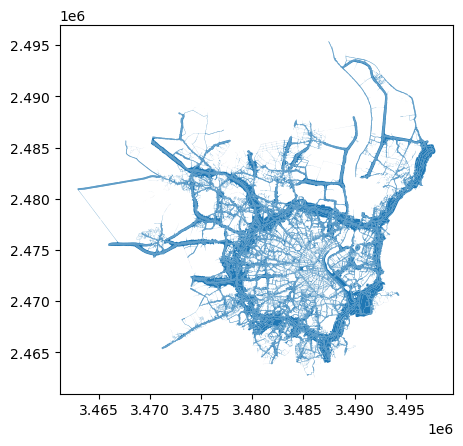

In [42]:
ncm_agl.plot()

In [23]:
ncm_dg = dg.from_geopandas(ncm, npartitions=10)
agl_city_dg = dg.from_geopandas(agl_city, npartitions=10)

In [25]:
ncm_dg_agl = ncm_dg.intersection(agl_city_dg)

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [31]:
ncm_dg_agl = ncm_dg.geometry.intersection(agl_city_dg.geometry).compute()

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [32]:
ncm_dg_agl

0      None
1      None
2      None
3      None
4      None
394    None
dtype: geometry

<AxesSubplot: >

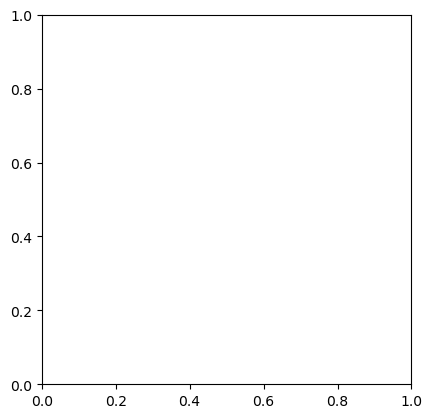

In [33]:
ncm_dg_agl.plot()

In [ ]:
agl_city = agls.query(f'agglomerationName_localName == "Bordeaux"')

In [ ]:
# setup the scenarios
engines = {
    'fiona+mask': {'engine': 'fiona', 'mask': agl_city},
    'pyogrio+arrow+bbox': {'engine': 'pyogrio', 'use_arrow': True, 'bbox': tuple(agl_city.total_bounds)}
}

# loop through the scenarios
times = []
for engine in engines:
    start_time = time.time()
    df = gpd.read_file(file_path, layer=layerName, **engines[engine])
    end_time = time.time()
    times.append(end_time - start_time)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(engines.keys(), times, color='skyblue')
axs[0].set_xlabel('Engine')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_title('Different masking times')

agl_city.plot(ax=axs[1], facecolor='none')
df.plot(ax=axs[1], zorder=-1, linewidth=0.5)
axs[1].set_title('Final dataset')